# Cathode surface concentrations for the electrochemical reduction of carbon dioxide in bicarbonate buffer solutions
Author: Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)

Solves **1D steady state** reaction-diffusion equations for CO<sub>2</sub>-bicarbonate-carbonate-hydroxide system using `SciPy`  
After Gattrell and co-workers  
>Gupta, N.; Gattrell, M.; MacDougall, B. Calculation for the Cathode Surface Concentrations in the Electrochemical Reduction of CO<sub>2</sub> in KHCO<sub>3</sub> Solutions. [J. Appl. Electrochem. **2006**, *36*, 161–172](http://link.springer.com/10.1007/s10800-005-9058-y).

# Initialize

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp

from units import *
from CO2parameters import * 

# Bulk equilibria
$$\require{mhchem}$$
As a first step one needs to solve for the bulk concentrations of bicarbonate and carbonate and for the pH for a given concentation of dissolved CO<sub>2</sub> and carbonate buffer concentration (e.g. KCO<sub>3</sub>, CsCO<sub>3</sub>, etc.)

CO<sub>2</sub>-bicarbonate-carbonate equations for acidic conditions:

$$\ce{CO2{(aq)} +H2O <=> HCO3- + H+}\tag{1a}$$
$$\ce{HCO3- + H2O  <=> CO3^2- + H+}\tag{2a}$$

Equivalently, and suitable for pH > 7, we can write them in the base form:

$$\ce{CO2{(aq)} + OH- <=> HCO3- }\tag{1b}$$
$$\ce{HCO3- + OH-  <=> CO3^2- + H2O}\tag{2b}$$

For this problem there 3 unknowns. The three equations used to solve for them are either the acid or base equilibria above (two equations) plus charge balance, written here for KHCO<sub>3</sub> buffer. 

$$ [\ce{H+}] + [\ce{K+}] = [\ce{OH-}] + [\ce{HCO3-}] + 2~[\ce{CO3^2-}] $$

Values for the equilibrium constants are in CO2parameters.py

**Programming notes**  

The root finder `fsolve` (same name as in Matlab) requires more help to solve the equations compared to *Mathematica*. For example, I was not able to figure out how to contrain the solutions to positive values. And it needs guesses to work properly. Guesses are generated by fitting splines between solutions at a number of buffer concentrations.  As a result, at present, the solves will only work for ~33 mm CO<sub>2</sub> (saturation condition for 1 atm) and between 10 and 1000 mM buffer.  

Values for the equilibrium constants and the rate constants are in the file [CO2parameters.py](CO2parameters.py), which is loaded at the begining of the notebook. The FEs for the cathode reactions are specified there as well.

In [2]:
# For troubleshoooting
# Correct answers for 33 mM and 100 mM buffer from Mathematica solver
# Slightly different values for K1 and K2 used.  
HplusCorrect=    1.4034e-7*molar;
OHminusCorrect = 7.1254e-8*molar;
HCO3correct =    9.9933e-2*molar;
CO3correct =     3.3397e-5*molar;

In [3]:
CO2bulk = 33.4*mM           # Calculated from Henry's law
buffer = 500*mM             # Change this value to get different buffer pH

# Written this way it is the acid equation. 
# So K1a and K2a are used.
# Using the equilibrium constants from the GGM paper. 

def CO2equations(x):
    Hplus, HCO3, CO3 = x
    return (np.log10(Hplus) + np.log10(HCO3) - np.log10(CO2bulk) - np.log10(K1a), \
            np.log10(Hplus)+ np.log10(CO3) - np.log10(HCO3) - np.log10(K2a), \
            Hplus + buffer - Kw/Hplus - HCO3 - 2* CO3 )

# Guesses - these are crucial. Guesses is a python tuple
# This section required more work to handle bulk pH near the pKa of carbonate

pHguess=interp1d([10,50,100,200,300,500,1000,1500],\
                 [5.85,6.55,6.85,7.15, 7.32,7.55, 7.85, 8.02],kind='cubic')
logCO3guess=interp1d([10,50,100,200,300,500,1000,1500],\
                 [-3.48148606, -2.078076083, -1.477555766, -0.876148359, \
                  -0.524328812, -0.080921908, 0.51851394,  3.171726454],kind='cubic')

guesses = (10**(-pHguess(buffer/mM).item(0))*molar,\
           np.abs(buffer-2*10**(logCO3guess(buffer/mM).item(0))*mM), \
           10**(logCO3guess(buffer/mM).item(0))*mM)

# Call the solver
HplusBulk, HCO3bulk, CO3bulk =  fsolve(CO2equations, guesses)
OHbulk = Kw/HplusBulk  

print ("CO2 (mM) =",f'{CO2bulk:3.1f}')
print ("buffer (mM)=",f'{buffer/mM:3.1f}')
print()
print ("pH =",f'{-np.log10(HplusBulk/molar):3.3f}')
print("HCO3(mM) =",f'{HCO3bulk/mM:3.2f}')
print("CO3(mM) =",f'{CO3bulk/mM:3.4f}')

CO2 (mM) = 33.4
buffer (mM)= 500.0

pH = 7.526
HCO3(mM) = 498.44
CO3(mM) = 0.7807


# ODE solver
$$\require{mhchem}$$
Consideration of the forward and reverse rates of reactions (1) and (2) above leads to the following equations for CO<sub>2</sub>, HCO<sub>3</sub><sup>-</sup>, CO<sub>3</sub><sup>2-</sup>, and OH<sup>-</sup> in the diffusion layer. 
In steady state, these 4 simultaneous ODEs need to be solved over [0, *L*], where *L* is the thickness of the diffusion layer (typically 100 microns). 

$$ 0 = D_{\ce{CO2}} \frac{d^2 [\ce{CO2}]}{dx^2} - [\ce{CO2}] [\ce{OH-}] k_{1f} + [\ce{HCO3-}]k_{1r}$$

$$ 0 = D_{\ce{HCO3-}} \frac{d^2 [\ce{HCO3-}]}{dx^2}
+ [\ce{CO2}] [\ce{OH-}] k_{1f} - [\ce{HCO3-}]k_{1r}  
- [\ce{HCO3-}] [\ce{OH-}] k_{2f} + [\ce{CO3^2-}] k_{2r}  $$

$$ 0 = D_{\ce{CO3^2-}} \frac{d^2 [\ce{CO3^2-}]}{dx^2}
+ [\ce{HCO3-}] [\ce{OH-}] k_{2f} - [\ce{CO3^2-}] k_{2r} $$

$$ 0 = D_{\ce{OH-}} \frac{d^2 [\ce{OH-}]}{dx^2} 
- [\ce{CO2}] [\ce{OH-}] k_{1f} + [\ce{HCO3-}]k_{1r} 
- [\ce{HCO3-}] [\ce{OH-}] k_{2f}+ [\ce{CO3^2-}] k_{2r}$$

Boundary conditions at *L* are the bulk concentrations from the equilibrium solver above. 

Molar flux boundary conditions for CO<sub>2</sub> and OH<sup>-</sup> determined by the current density *j* and the assumed Faradaic efficiencies. For 100% FE for CO, they are:

$$ \frac {d [\ce{CO2}]}{dx} \bigg\lvert _{x=0} = \frac {-1}{D_{\ce{CO2}}} \left( \frac{j}{F} \right) \frac{1}{2} $$
$$ \frac {d [\ce{OH-}]}{dx} \bigg\lvert _{x=0} = \frac {1}{D_{\ce{OH-}}} \left( \frac{j}{F} \right)  $$

Two electrons are required to make one CO. The reaction consumes two protons, so two hydroxide ions are produced, assuming that water equilibrium is infinitly fast. Flux boundary conditions for bicarbonate and carbonate are zero. The current density *j* is negative for cathodic currents. 

## Geometry and boundary conditions
*L*, the thickness of the diffusion layer, and the current density *j* are set here  
FE values are loaded in [CO2parameter.py](CO2parameters.py). Addition products such as ethanol, acetate, and propanol could be added there.  

In [4]:
L =    100 * micron;        # width of diffusion layer. 
jTotal = -5 * mA*cm**-2;     # Note negative sign for cathodic current

# Flux boundary conditions. Note that the depend on the FEs and also on the 
#  values of z, the number of electrons tranferred to make a given product. 
g0CO2 = -DCO2**-1 * (jTotal/F) * (FEmethane/zMethane    + \
                                FEformate/zFormate    +  \
                                FECO/zCO              +  \
                                2*(FEethylene/zEthylene) ) ; # 2 for C2 product
                          
                               
g0OH = +DOH**-1 *(jTotal/F) * ( 8*(FEmethane/zMethane) + \
                                FEformate/zFormate      + \
                                2*(FECO/zCO)            + \
                                12*(FEethylene/zEthylene) + \
                                2*(FEH2/zH2)) ;   # Added - was missing in GGM

g0HCO3  = 0;   # no reaction at electrode for bicarbonate
g0CO3   = 0;   # no reaction at elecrode for carbonate

## Setting up the solver
The ODEs and the boundary conditions

In [5]:
# note np.vstack for the equations and np.array for the boundary conditions.
#  Had to change the indexing by 1 when adapting from the Matlab codes, as
#  Matlab is 1-based and python is 0-based.
#
# The 4 2nd order ODEs are cast as 8 first order ODEs
# Odd terms are the first derivatives
# Even terms are concentrations
# y[0] is CO2,  y[1] is dCO2/dx
# y[2] is HCO3, y[3] is dHCO3/dx
# y[4] is CO3,  y[5] is dCO3/dx
# y[6] is OH-,  y[7] is dOH/dx

def CO2RODEs(x, y):    # defined here in pairs, 2 for each species
    return np.vstack(( y[1], -DCO2**-1*(-k1f*y[0]*y[6] + k1r*y[2]),\
                       y[3], -DHCO3**-1*(+k1f*y[0]*y[6] - k1r*y[2] - k2f*y[2]*y[6] + k2r*y[4]),\
                       y[5], -DCO3**-1*( k2f*y[2]*y[6] - k2r*y[4]),\
                       y[7], -DOH**-1*( -k1f*y[0]*y[6] + k1r*y[2] - k2f*y[2]*y[6] + k2r*y[4]) )) 

# note that np.array is used here not np.vstack
# x=0 BCs will be fluxes (odd indices) and x=L BCs will be concentrations (even indices)

def CO2RBCs(y0, yL):   # in pairs, the x=0 and x=L BCs for each species
    return np.array (( y0[1]-g0CO2, yL[0] - CO2bulk,\
                       y0[3]-g0HCO3, yL[2]-HCO3bulk,\
                       y0[5]-g0CO3, yL[4]-CO3bulk,\
                       y0[7]-g0OH, yL[6]-OHbulk )) 

## Calling the ODE solver
`solve_bvp` is similar to `bvp5c` in Matlab.  
There does not appear to be a function similar to Matlab's `pdepe` in `scipy` otherwise it would be possible to do the PDEs (with time dependence)

In [6]:
nNodes = 100                         # inital number of nodes, solver will add more if needed
x = np.linspace(0, L, nNodes)        # creates nodes between 0 and the boundary

# for guesses it needs an arriay with 8 columns and nNodes rows.
#  So use np.stack and np.full to construct this. 
y_guess= np.stack(( np.full((nNodes,),CO2bulk),np.full((nNodes,), CO2bulk/L),\
                    np.full((nNodes,),HCO3bulk),np.full((nNodes,), HCO3bulk/L),\
                    np.full((nNodes,),CO3bulk), np.full((nNodes,),-CO3bulk/L),\
                    np.full((nNodes,),OHbulk),  np.full((nNodes,),-OHbulk/L) ))                    

# Calling the solver. It returns a structure
CO2Rsolution = solve_bvp(CO2RODEs, CO2RBCs, x, y_guess, verbose = 2)    

# Sampling the solution for the plots
# One could also use the mesh points, they are in CO2Rsolution.x and the solution values
#  which are in CO2Rsolution.y. 
nPlot = 100
x_plot = np.linspace(0, L, nPlot)

CO2sol = CO2Rsolution.sol(x_plot)[0]
HCO3sol =CO2Rsolution.sol(x_plot)[2]
CO3sol = CO2Rsolution.sol(x_plot)[4]
OHsol =  CO2Rsolution.sol(x_plot)[6]
pHsol = -np.log10((Kw/OHsol)/molar)

# For computing fluxes get the gradients
dCO2dz=  CO2Rsolution.sol(x_plot)[1]
dHCO3dz= CO2Rsolution.sol(x_plot)[3]
dCO3dz=  CO2Rsolution.sol(x_plot)[5]
dOHdz =  CO2Rsolution.sol(x_plot)[7]


print('**********')
print('Bulk CO2 (mM)    = ' + f'{CO2bulk/mM:3.2f}')
print('Buffer (mM)      = ' + f'{buffer/mM:3.2f}')
print('Bulk pH          = ' + f'{-np.log10(HplusBulk/molar):3.3f}')
print()
print('j (mA cm-2)      = ' + f'{jTotal/(mA*cm**-2):3.2f}')
print()
print(''+'\tCH4'+'\tC2H4'+'\tCO'+'\tformate'+ '\tH2')
print('FE\t'+f'{FEmethane:3.2f}'+'\t'+f'{FEethylene:3.2f}'+'\t'+f'{FECO:3.1f}''\t'+f'{FEformate:3.2f}''\t'+f'{FEH2:3.2f}')
print()
print('surface CO2 (mM) = ' + f'{CO2sol[0]/mM:3.2f}')
print('surface pH       = ' + f'{pHsol[0]:3.2f}')

   Iteration    Max residual    Total nodes    Nodes added  
       1          5.44e+01          100            198      
       2          5.84e+01          298            203      
       3          2.42e+01          501            66       
       4          1.91e+00          567            26       
       5          1.74e+00          593            29       
       6          1.08e-01          622            46       
       7          1.58e-02          668             3       
       8          9.56e-04          671             0       
Solved in 8 iterations, number of nodes 671, maximum relative residual 9.56e-04.
**********
Bulk CO2 (mM)    = 33.40
Buffer (mM)      = 500.00
Bulk pH          = 7.526

j (mA cm-2)      = -5.00

	CH4	C2H4	CO	formate	H2
FE	0.00	0.00	0.0	1.00	0.00

surface CO2 (mM) = 17.69
surface pH       = 9.05


# Plotting and visualization

## Summary plot

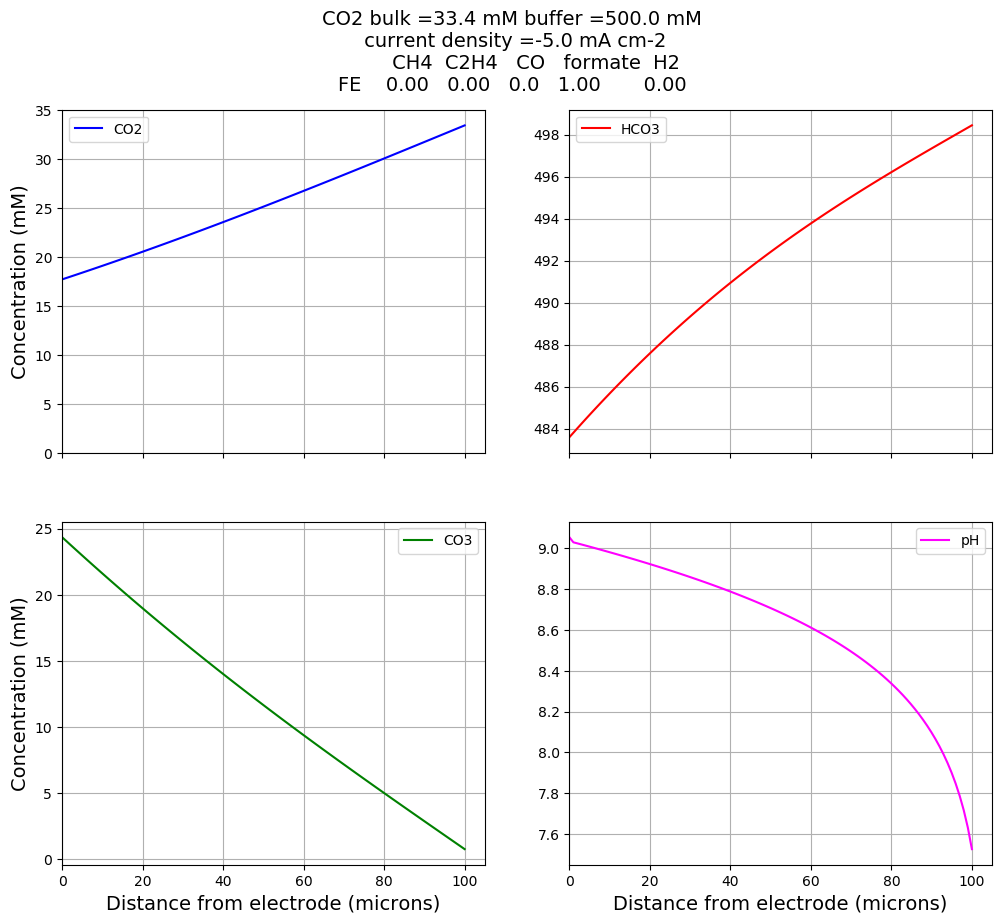

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', figsize = (12,10), dpi=100)
fig.suptitle('CO2 bulk ='+  f'{CO2bulk/mM:3.1f}'  +' mM' + \
             ' buffer ='+  f'{buffer/mM:3.1f}'  +' mM' + \
             '\n current density ='+  f'{jTotal/(mA*cm**-2):3.1f}' + ' mA cm-2'+'\n' + \
             '         CH4  C2H4   CO   formate  H2 \n' + \
             'FE    '+ f'{FEmethane:3.2f}'+'   '+ f'{FEethylene:3.2f}' +'   '+ f'{FECO:3.1f}'+\
             '   '+f'{FEformate:3.2f}'+ '       '+f'{FEH2:3.2f}', \
             fontsize=14)
ax1.plot(x_plot/micron,CO2sol/mM, 'b', label='CO2')
ax1.grid(True)
ax1.set_xlim(0,105)
ax1.set_ylim(0,35)
ax1.set_ylabel('Concentration (mM)', fontsize=14)
ax1.legend(loc='best')

ax2.plot(x_plot/micron,HCO3sol/mM, 'r', label='HCO3')
ax2.legend(loc='best')
ax2.set_xlim(0,105)
ax2.grid(True)

ax3.plot(x_plot/micron,CO3sol/mM, 'g', label='CO3')
ax3.set_xlabel('Distance from electrode (microns)', fontsize=14)
ax3.set_ylabel('Concentration (mM)', fontsize=14)
ax3.set_xlim(0,105)
ax3.grid(True)
ax3.legend(loc='best')

ax4.plot(x_plot/micron,pHsol, 'magenta', label='pH')
ax4.set_xlabel('Distance from electrode (microns)', fontsize=14)
ax4.set_xlim(0,105)
ax4.grid(True)
ax4.legend(loc='best')

plt.show()


## Individual concentration plots

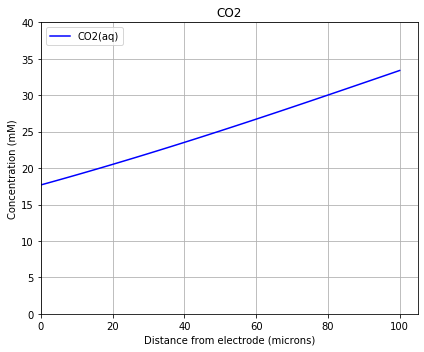

In [8]:
plt.figure(figsize=(6,5))
plt.plot(x_plot/micron,CO2sol/mM, 'b', label='CO2(aq)')    #same nomenclature as Matlab
plt.legend(loc='upper left')
plt.title('CO2')
plt.xlabel("Distance from electrode (microns)")
plt.ylabel("Concentration (mM)")
plt.xlim((0,105))
plt.ylim((0,40))
plt.grid()
plt.tight_layout()
plt.show()

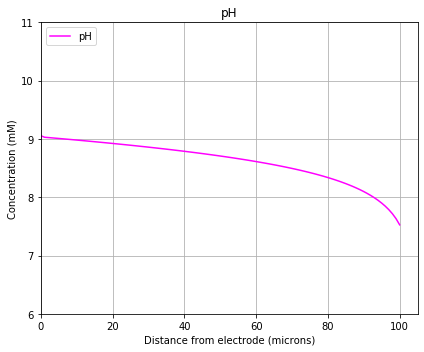

In [9]:
plt.figure(figsize=(6,5))
plt.plot(x_plot/micron,pHsol, 'magenta', label='pH')    #same nomenclature as Matlab
plt.legend(loc='upper left')
plt.title('pH')
plt.xlabel("Distance from electrode (microns)")
plt.ylabel("Concentration (mM)")
plt.xlim((0,105))
plt.ylim((6,11))
plt.grid()
plt.tight_layout()
plt.show()

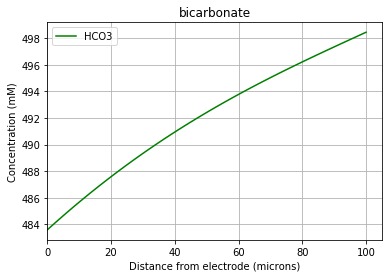

In [10]:
plt.plot(x_plot/micron,HCO3sol/mM, 'g', label='HCO3')    #same nomenclature as Matlab
plt.legend()
plt.title('bicarbonate')
plt.xlabel("Distance from electrode (microns)")
plt.ylabel("Concentration (mM)")
plt.xlim((0,105))
plt.grid()
plt.show()

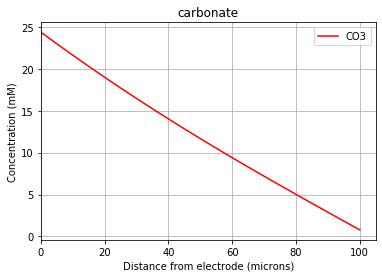

In [11]:
plt.plot(x_plot/micron,CO3sol/mM, 'r', label='CO3')    #same nomenclature as Matlab
plt.legend()
plt.title('carbonate')
plt.xlabel("Distance from electrode (microns)")
plt.ylabel("Concentration (mM)")
plt.xlim((0,105))
plt.grid()
plt.show()

## Checking the molar fluxes
The total carbon flux should be constant through the diffusion layer.

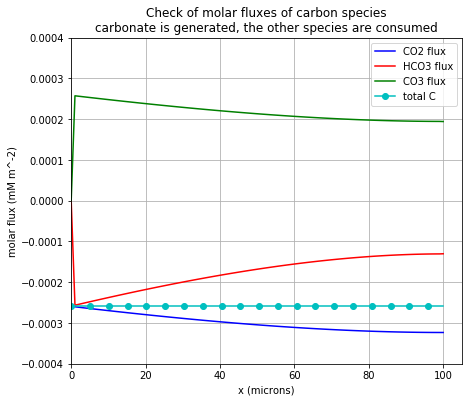

In [12]:
plt.figure(figsize=(7,6))
plt.plot(x_plot/micron,-DCO2*dCO2dz,'-b',label='CO2 flux')
plt.plot(x_plot/micron,-DHCO3*dHCO3dz,'-r', label='HCO3 flux')
plt.plot( x_plot/micron,-DCO3*dCO3dz,'-g', label='CO3 flux')
plt.plot(x_plot/micron,-DCO2*dCO2dz+-DHCO3*dHCO3dz+-DCO3*dCO3dz,'-co', label='total C', markevery=5)
plt.title('Check of molar fluxes of carbon species\ncarbonate is generated, the other species are consumed')
plt.legend(loc='best')
plt.xlim(0,105)
plt.ylim(-0.0004,+0.0004 )
plt.xlabel('x (microns)')
plt.ylabel('molar flux (mM m^-2)')
plt.grid()
plt.show()

## Comparing to equilibrium
One can see that reaction (1b) is out of equilibrium due to $k_{1f}$ being slow whereas reaction (2b) is fast in both directions and is in equilibium.  

$$\ce{CO2{(aq)} + OH- <=> HCO3- }\tag{1b}$$
$$\ce{HCO3- + OH-  <=> CO3^2- + H2O}\tag{2b}$$

This is good, because a faster $k_{1f}$ would lower the CO<sub>2</sub> concentration at the surface and lower the mass-transport-limited current density. 

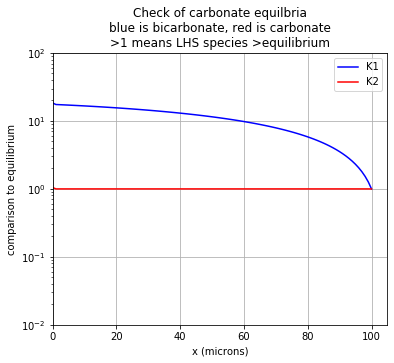

In [13]:
plt.figure(figsize=(6,5))
plt.semilogy(x_plot/micron,((OHsol*CO2sol)/HCO3sol)/(k1r/k1f),'-b', label = 'K1') 
plt.semilogy(x_plot/micron, ((OHsol*HCO3sol)/CO3sol)/(k2r/k2f),'-r', label = 'K2' )
plt.title('Check of carbonate equilbria\n' + \
       'blue is bicarbonate, red is carbonate'+ \
       '\n>1 means LHS species >equilibrium')
plt.xlim(0,105)
plt.ylim(1e-2,1e+2)
plt.legend(loc='best')
plt.grid()
plt.xlabel('x (microns)')
plt.ylabel('comparison to equilibrium')
plt.show()